In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import torch
import torch.nn as nn
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, precision_recall_curve,
    average_precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as _acc
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from loguru import logger




project_root = Path().resolve()
sys.path.append(str(project_root / "src"))

from dataset.custom_data import IMDBDataset
from models.dnn import DNN
from models.rnn import RNN
from models.lstm import LSTM



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Code is running on: {device}")

2025-08-10 17:18:56.688 | INFO     | __main__:<module>:36 - Code is running on: cuda


In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20, 6)
sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", None)

HTML("""
<style>
.container { width:100% !important; }
.output_png { display: block; margin-left: auto; margin-right: auto; }
</style>
""")

In [3]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total, loss_sum, correct = 0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float().to(device)
        optimizer.zero_grad()
        logits = model(xb)                   # (B,)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        loss_sum += float(loss.item()) * yb.size(0)
        preds = (logits.sigmoid() >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0)
    return loss_sum/total, correct/total

In [4]:
@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total, loss_sum, correct = 0, 0.0, 0
    all_y, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float().to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss_sum += float(loss.item()) * yb.size(0)
        probs = logits.sigmoid()
        preds = (probs >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0)
        all_y.append(yb.cpu().numpy()); all_p.append(preds.cpu().numpy())
    y = np.concatenate(all_y); p = np.concatenate(all_p)
    return loss_sum/total, correct/total, y, p

In [5]:
def plot_history(history, best_epoch=None):
    epochs = history["epoch"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train")
    axes[0].plot(epochs, history["val_loss"],   label="Valid")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].legend()
    if best_epoch is not None and best_epoch in epochs:
        axes[0].axvline(best_epoch, ls="--", alpha=0.5)

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train")
    axes[1].plot(epochs, history["val_acc"],   label="Valid")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    if best_epoch is not None and best_epoch in epochs:
        axes[1].axvline(best_epoch, ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


In [6]:
def make_snapshot_path(model, best_acc):
    snapshot_dir = project_root / "models"
    snapshot_dir.mkdir(parents=True, exist_ok=True)
    
    name = f"{model.__class__.__name__}_acc_{best_acc:.4f}.pt"
    return snapshot_dir / name

In [7]:
def model_trainer(model, optimizer, criterion):
    best_acc = 0.0
    patience = 3
    patience_counter = 0
    best_path = None
    best_epoch = None
    
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in tqdm(range(1, 11), desc="Epochs"):
        tr_loss, tr_acc = train_epoch(model, tqdm(train_loader, desc=f"Train {epoch}", leave=False),
                                      optimizer, criterion)
        te_loss, te_acc, y_true, y_pred = eval_epoch(model, tqdm(test_loader, desc=f"Eval  {epoch}", leave=False),
                                                     criterion)
    
        # log
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(te_loss)
        history["val_acc"].append(te_acc)
        
        tqdm.write(f"Epoch {epoch}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} "
                   f"val_loss={te_loss:.4f} val_acc={te_acc:.4f}")
    
        if te_acc > best_acc:
            best_acc = te_acc
            patience_counter = 0
            best_path = make_snapshot_path(model, best_acc)
            best_epoch = epoch
            torch.save(model.state_dict(), best_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch} (best val_acc={best_acc:.4f})")
                break
    
    # reload best
    assert best_path is not None
    model.load_state_dict(torch.load(best_path, map_location=device))
    
    # final report
    _, _, y_true, y_pred = eval_epoch(model, test_loader, criterion)
    logger.success(f"Best model: {best_path}")
    print(classification_report(y_true, y_pred, target_names=["neg","pos"]))
    
    plot_history(history, best_epoch=best_epoch)

In [8]:
df = pd.read_parquet(project_root / "data" / "imdb_reviews.parquet")
df = df[["review", "sentiment"]].dropna().reset_index(drop=True)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["review"].astype(str), df["sentiment"].astype(int), test_size=0.2, random_state=42, stratify=df["sentiment"]
)

In [9]:
train_dataset = IMDBDataset(
    texts = X_train_text,
    labels = y_train,
    max_len=256, 
    preprocess=True, 
    min_freq=2, 
    max_vocab_size=30000, 
    language="english"
)


test_dataset = IMDBDataset(
    texts = X_test_text,
    labels = y_test,
    max_len=256, 
    preprocess=True, 
    min_freq=2, 
    max_vocab_size=30000, 
    language="english"
)


test_dataset.vocab = train_dataset.vocab

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

In [12]:
dnn = DNN(vocab_size=len(train_dataset.vocab), emb_dim=128, hidden_dim=64, dropout=0.3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-3)

model_trainer(dnn, optimizer, criterion)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  1:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4583 train_acc=0.7891 val_loss=0.3189 val_acc=0.8722


Train 2:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  2:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 2: train_loss=0.2541 train_acc=0.9013 val_loss=0.2795 val_acc=0.8876


Train 3:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  3:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 3: train_loss=0.1909 train_acc=0.9301 val_loss=0.2740 val_acc=0.8907


Train 4:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  4:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1480 train_acc=0.9492 val_loss=0.2899 val_acc=0.8900


Train 5:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  5:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1147 train_acc=0.9631 val_loss=0.3148 val_acc=0.8885


Train 6:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  6:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0885 train_acc=0.9740 val_loss=0.3530 val_acc=0.8856
Early stopping at epoch 6 (best val_acc=0.8907)


2025-08-10 17:19:35.971 | SUCCESS  | __main__:model_trainer:44 - Best model: J:\IMDB_Macromill\models\DNN_acc_0.8907.pt


              precision    recall  f1-score   support

         neg       0.90      0.88      0.89      4940
         pos       0.89      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



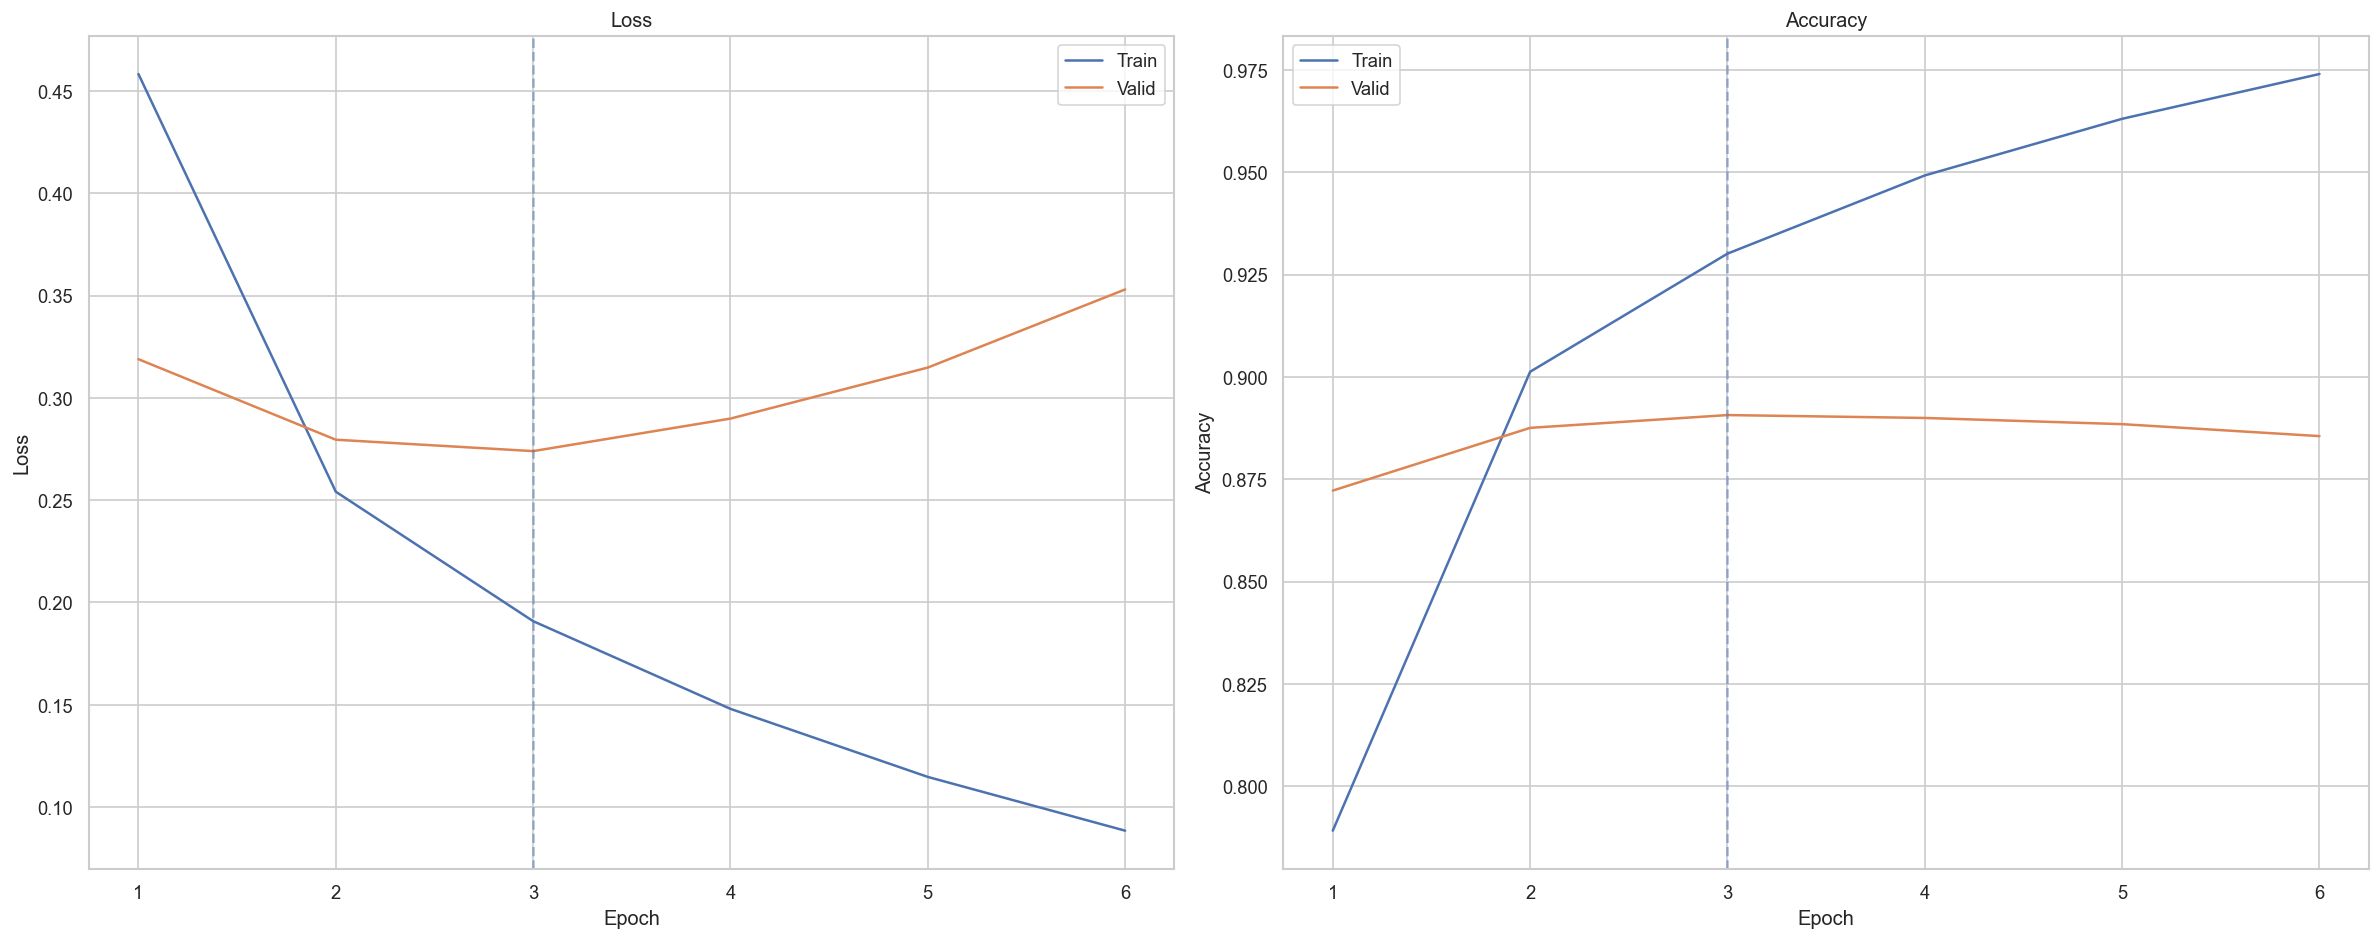

## RNN Results and Changes

### Initial RNN Attempt
- **Architecture**:
  - Embedding dimension: 128
  - Hidden size: 128
  - 1 layer
  - Unidirectional
  - Dropout: None
- **Performance**:
  - Best validation accuracy: **0.5133**
  - Model failed to learn meaningful patterns; accuracy hovered near random chance (0.50).
  - Training loss did not decrease significantly; signs of underfitting.

---

In [12]:
rnn = RNN(
    vocab_size=len(train_dataset.vocab),
    emb_dim=256,
    hidden_size=256,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)


model_trainer(rnn, optimizer, criterion)

ting.

---

### Modified RNN Attempt
- **Changes Made**:
  1. Increased **embedding dimension** from 128 → 256 to give richer token representations.
  2. Increased **hidden size** from 128 → 256 to improve capacity.
  3. Increased **number of layers** from 1 → 2 for deeper sequence modeling.
  4. Enabled **bidirectional** RNN to capture context from both directions.
  5. Added **dropout=0.3** to reduce overfitting and stabilize training.

- **Performance After Changes**:
  - Best validation accuracy: **0.8138**
  - Training accuracy improved to ~0.81–0.83 before early stopping.
  - Significant jump from near-random performance to competitive accuracy.
  - Model converged in fewer than 10 epochs.

---

### Conclusion
- The initial RNN setup was too shallow and lacked regularization, leading to poor performance.
- Increasing embedding and hidden dimensions, using more layers, adding bidirectionality, and applying dropout transformed the model’s learning ability and overall accuracy.

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  1:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5617 train_acc=0.7100 val_loss=0.4616 val_acc=0.7854


Train 2:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  2:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 2: train_loss=0.3615 train_acc=0.8479 val_loss=0.3099 val_acc=0.8717


Train 3:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  3:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 3: train_loss=0.2332 train_acc=0.9126 val_loss=0.2876 val_acc=0.8812


Train 4:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  4:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1659 train_acc=0.9415 val_loss=0.3392 val_acc=0.8788


Train 5:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  5:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1056 train_acc=0.9662 val_loss=0.3273 val_acc=0.8834


Train 6:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  6:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0739 train_acc=0.9774 val_loss=0.3844 val_acc=0.8836


Train 7:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  7:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0496 train_acc=0.9850 val_loss=0.4486 val_acc=0.8864


Train 8:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  8:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0378 train_acc=0.9891 val_loss=0.4806 val_acc=0.8832


Train 9:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  9:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0299 train_acc=0.9913 val_loss=0.5079 val_acc=0.8769


Train 10:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  10:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 10: train_loss=0.0247 train_acc=0.9929 val_loss=0.4750 val_acc=0.8822
Early stopping at epoch 10 (best val_acc=0.8864)


2025-08-10 17:26:32.992 | SUCCESS  | __main__:model_trainer:44 - Best model: J:\IMDB_Macromill\models\LSTM_acc_0.8864.pt


              precision    recall  f1-score   support

         neg       0.89      0.88      0.89      4940
         pos       0.88      0.89      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



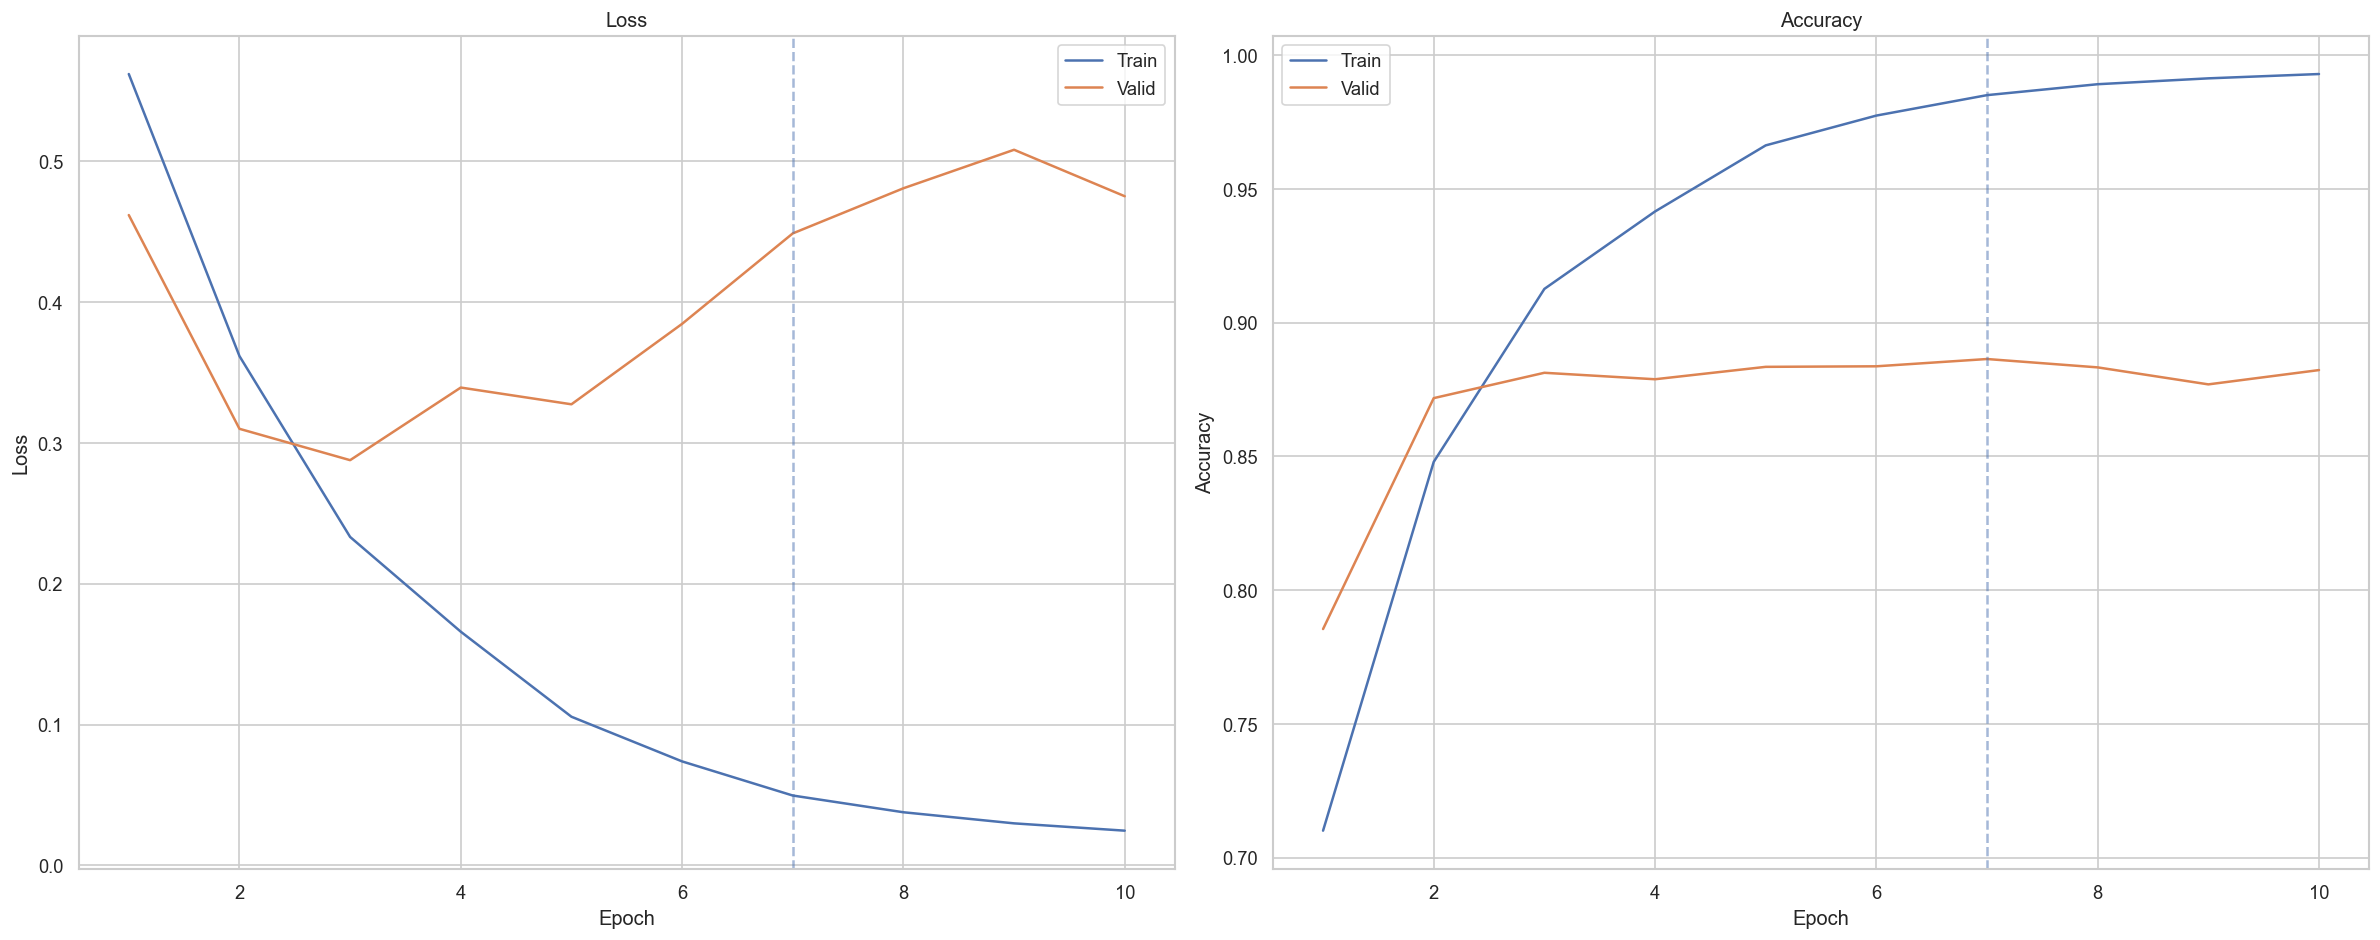

In [15]:
model_lstm = LSTM(
    vocab_size=len(train_dataset.vocab),
    emb_dim=256,
    hidden_dim=128,
    num_layers=2,
    bidirectional=True,
    dropout=0.4,
    pad_idx=0,
).to(device)

criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

model_trainer(model_lstm, optimizer_lstm, criterion_lstm)